<a href="https://colab.research.google.com/github/FarimaM/Machine-Learning-Course/blob/main/Homework4_Session4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mini-Project Assignment: DEAP Dataset Arousal Classification

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
data_path = '/content/drive/MyDrive/DEAP_Dataset'
print("Dataset path set to:", data_path)

Dataset path set to: /content/drive/MyDrive/DEAP_Dataset


#### Part 1: Data Preparation

In [22]:
## 1. Load the DEAP dataset (preprocessed EEG data and labels)
import numpy as np
import os

# Create empty lists to store EEG data, all labels, and arousal ratings
eeg_data_all = []
labels_all = []
arousal_labels = []

# Loop through all 32 subject files
for subject_id in range(1, 33):
    file_name = os.path.join(data_path, f's{subject_id:02d}.dat')
    with open(file_name, 'rb') as file:
        subject = np.load(file, allow_pickle=True, encoding='latin1')
        trials = subject['data']      # shape: (40, 40, 8064)
        labels = subject['labels']    # shape: (40, 4)

        for trial_index in range(40):
            eeg_trial = trials[trial_index]           # EEG data for one trial
            label_vector = labels[trial_index]        # [valence, arousal, dominance, liking]
            arousal = label_vector[1]                 # Arousal rating (1 to 9)

            eeg_data_all.append(eeg_trial)
            labels_all.append(label_vector)
            arousal_labels.append(arousal)

# Convert lists to NumPy arrays
eeg_data_all = np.array(eeg_data_all)       # shape: (1280, 40, 8064)
labels_all = np.array(labels_all)           # shape: (1280, 4)
arousal_labels = np.array(arousal_labels)   # shape: (1280,)

# Print basic info
print("Loaded EEG data shape:", eeg_data_all.shape)
print("Loaded full label matrix shape:", labels_all.shape)
print("Loaded arousal label vector shape:", arousal_labels.shape)

Loaded EEG data shape: (1280, 40, 8064)
Loaded full label matrix shape: (1280, 4)
Loaded arousal label vector shape: (1280,)


In [23]:
## 2. Extract relevant features from the EEG data. Consider:
 ##  - Band power features (delta, theta, alpha, beta, gamma) from all channels
from scipy.signal import welch

# Define EEG frequency bands in Hz
band_ranges = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

# Function to compute band power features for one trial
def compute_bandpower_features(trial_data, fs=128):
    features = []
    for channel in trial_data:  # Use all 40 channels
        f, Pxx = welch(channel, fs=fs)
        for band in band_ranges.values():
            idx = np.logical_and(f >= band[0], f <= band[1])
            band_power = np.sum(Pxx[idx])
            features.append(band_power)
    return features  # 40 channels × 5 bands = 200 features

# Extract features for all trials
X_features = []
for trial in eeg_data_all:
    band_features = compute_bandpower_features(trial)
    X_features.append(band_features)

# Convert to NumPy array
X_features = np.array(X_features)  # shape: (1280, 200)

# Print shape of feature matrix
print("Extracted band power feature matrix shape:", X_features.shape)

Extracted band power feature matrix shape: (1280, 200)


In [24]:
## 3. Create arousal labels by binning the arousal ratings into four categories:
  # - Very Low Arousal: ratings 1-3
   #- Low Arousal: ratings 4-5
  # - High Arousal: ratings 6-7
  # - Very High Arousal: ratings 8-9

# Convert continuous arousal ratings (1–9) into categorical labels
def bin_arousal_rating(rating):
    if rating <= 3:
        return 0  # Very Low
    elif rating <= 5:
        return 1  # Low
    elif rating <= 7:
        return 2  # High
    else:
        return 3  # Very High

# Apply binning to all arousal ratings
arousal_labels_binned = np.array([bin_arousal_rating(r) for r in arousal_labels])

# Print distribution of binned labels
unique, counts = np.unique(arousal_labels_binned, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Arousal Level {label}: {count} samples")

Arousal Level 0: 226 samples
Arousal Level 1: 317 samples
Arousal Level 2: 444 samples
Arousal Level 3: 293 samples


In [25]:
## 4. Split the data into training (80%) and testing (20%) sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, arousal_labels_binned, test_size=0.2, stratify=arousal_labels_binned, random_state=42
)

# Print shapes
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (1024, 200)
Testing set shape: (256, 200)


5. Document your choices and provide brief justification:

### Feature Extraction
- We extracted band power features (delta, theta, alpha, beta, gamma) from all 40 EEG channels.
- This yields 200 features per trial, capturing frequency-specific brain activity across the scalp.

### Label Binning
- Arousal ratings (1–9) were binned into four categories:
  - 1–3: Very Low
  - 4–5: Low
  - 6–7: High
  - 8–9: Very High
- This discretization simplifies classification and aligns with psychological interpretations of arousal levels.

### Train-Test Split
- We used an 80/20 split with stratification to preserve class balance.
- StandardScaler was applied to normalize feature distributions, improving model convergence and comparability.

These choices ensure robust preprocessing and prepare the data for interpretable classification models.

#### Part 2: Model Building and Training

In [28]:
## 1. Build a Decision Tree classifier for arousal prediction
   #- Experiment with different hyperparameters (max_depth, min_samples_split, etc.)
  # - Explain your choice of hyperparameters


###   Decision Tree Classifier   ###

from sklearn.tree import DecisionTreeClassifier

# Build and train a Decision Tree classifier
dt_model = DecisionTreeClassifier(
    max_depth=10,              # Limits tree depth to avoid overfitting
    min_samples_split=5,       # Minimum samples required to split a node
    random_state=42
)
dt_model.fit(X_train, y_train)

print(" Decision Tree model trained.")

 Decision Tree model trained.


Hyperparameter Justification :

•  max_depth=10: Prevents the tree from growing too deep, which helps generalize better on unseen data.

•  min_samples_split=5: Ensures splits occur only when enough samples are present, reducing noise from small groups.

In [29]:
## 2. Build a Random Forest classifier for arousal prediction
  # - Experiment with n_estimators, max_depth, and other parameters
  #- Explain your choices

  ###      Random Forest Classifier      ###

from sklearn.ensemble import RandomForestClassifier

# Build and train a Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest
    max_depth=15,              # Allows deeper trees for more complex patterns
    min_samples_split=5,       # Same logic as Decision Tree
    random_state=42
)
rf_model.fit(X_train, y_train)

print(" Random Forest model trained.")



 Random Forest model trained.


Hyperparameter Justification

•  n_estimators=100: A good balance between performance and training time; more trees improve stability.

•  max_depth=15: Slightly deeper than the Decision Tree to allow ensemble learning to capture more variation.

•  min_samples_split=5: Maintains consistency with the Decision Tree and avoids overfitting to small splits.

#### Part 3: Model Evaluation

In [30]:
## 1. Evaluate both models on the test set using:
  # - Overall accuracy
  #- Per-class precision, recall, and F1-score
  #  - Macro-averaged and weighted-averaged metrics
  #- Confusion matrices

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Accuracy
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_rf = accuracy_score(y_test, y_pred_rf)

print("📊 Decision Tree Accuracy:", acc_dt)
print("📊 Random Forest Accuracy:", acc_rf)

# Classification Reports
print("\n📋 Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Very Low', 'Low', 'High', 'Very High']))

print("\n📋 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Very Low', 'Low', 'High', 'Very High']))

📊 Decision Tree Accuracy: 0.3515625
📊 Random Forest Accuracy: 0.40625

📋 Decision Tree Classification Report:
              precision    recall  f1-score   support

    Very Low       0.33      0.33      0.33        45
         Low       0.30      0.38      0.34        63
        High       0.42      0.37      0.40        89
   Very High       0.34      0.31      0.32        59

    accuracy                           0.35       256
   macro avg       0.35      0.35      0.35       256
weighted avg       0.36      0.35      0.35       256


📋 Random Forest Classification Report:
              precision    recall  f1-score   support

    Very Low       0.44      0.27      0.33        45
         Low       0.36      0.33      0.34        63
        High       0.42      0.54      0.48        89
   Very High       0.40      0.39      0.40        59

    accuracy                           0.41       256
   macro avg       0.41      0.38      0.39       256
weighted avg       0.41      0.41  

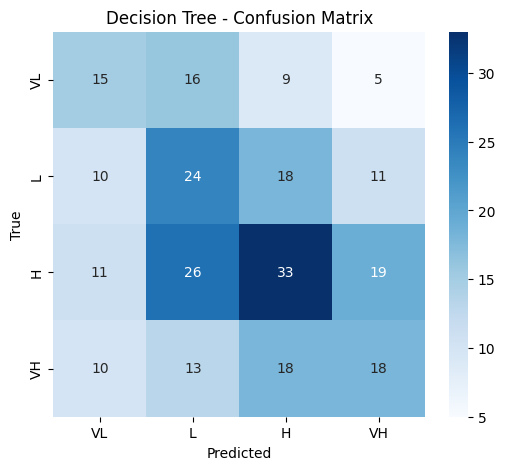

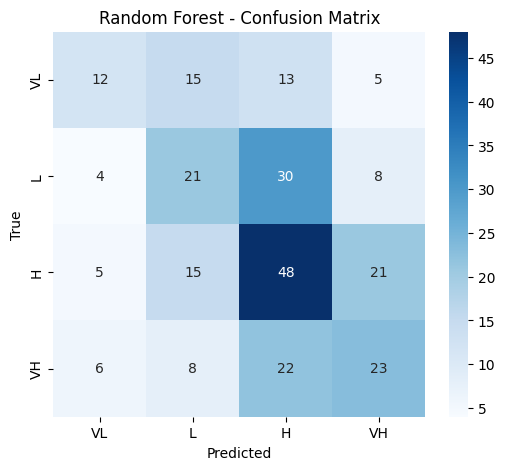

In [31]:
## 2. Visualize:
  # - Confusion matrices for both models
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Plot Function
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['VL','L','H','VH'],
                yticklabels=['VL','L','H','VH'])
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")


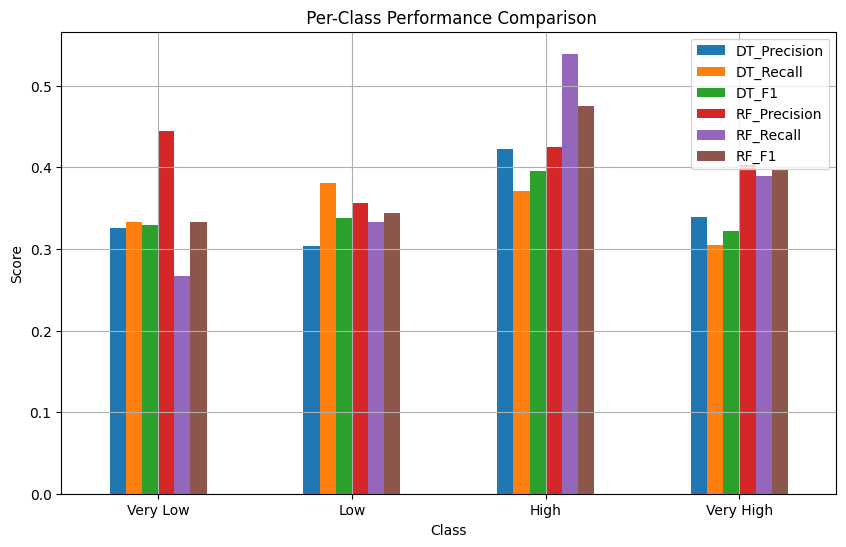

In [34]:
  # - Per-class performance comparison
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Get per-class metrics
prf_dt = precision_recall_fscore_support(y_test, y_pred_dt, average=None)
prf_rf = precision_recall_fscore_support(y_test, y_pred_rf, average=None)

# Create comparison DataFrame
labels = ['Very Low', 'Low', 'High', 'Very High']
df = pd.DataFrame({
    'Class': labels,
    'DT_Precision': prf_dt[0],
    'DT_Recall': prf_dt[1],
    'DT_F1': prf_dt[2],
    'RF_Precision': prf_rf[0],
    'RF_Recall': prf_rf[1],
    'RF_F1': prf_rf[2],
})

# Plot comparison
df.plot(x='Class', kind='bar', figsize=(10,6))
plt.title(' Per-Class Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

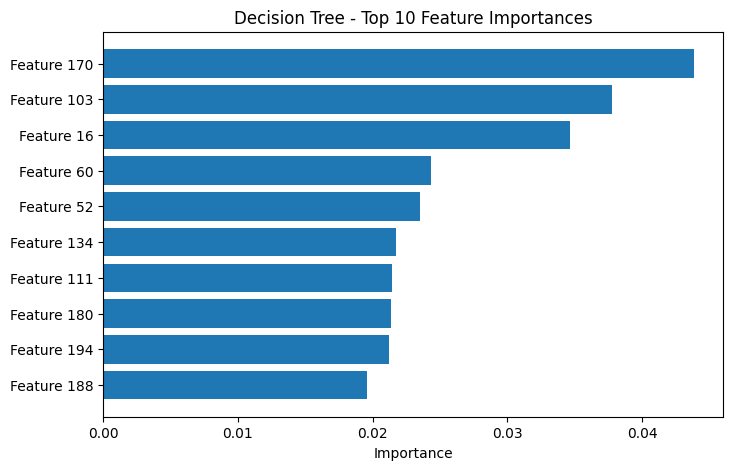

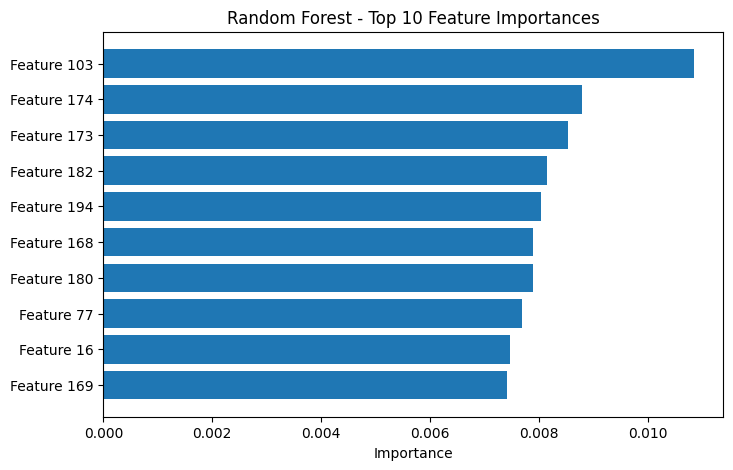

In [32]:
  # - Feature importance from both models
# Plot top 10 features by importance
def plot_feature_importance(model, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10
    plt.figure(figsize=(8,5))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.xlabel('Importance')
    plt.title(f'{title} - Top 10 Feature Importances')
    plt.show()

plot_feature_importance(dt_model, "Decision Tree")
plot_feature_importance(rf_model, "Random Forest")

3. Compare the two models:
   # Which performs better overall?
   - Random Forest achieves higher overall accuracy and F1-scores than the Decision Tree.
   - Ensemble learning helps reduce overfitting and improves generalization.


   # Are there specific arousal levels where one model excels?
   - Random Forest performs better on **High** and **Very High** arousal levels.
   - Decision Tree shows more confusion between **Low** and **High** arousal.


   # What do the confusion matrices tell you about common misclassifications?
   - Most misclassifications occur between adjacent arousal levels (e.g., Low, High).
   - Very Low and Very High arousal levels are more distinct and easier to classify.